In [214]:
%matplotlib inline  
import gc
import pickle
import librosa
import random
from multiprocessing import Pool
import numpy as np 
import pandas as pd
from tensorflow import keras
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from tensorflow import keras
from numpy import random
import librosa
import numpy as np
import glob
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [215]:
# !unzip -qq Archive.zip

In [216]:
input_length = 5000*1

batch_size = 8

def audio_norm(data):

    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5

def load_audio_file(file_path, input_length=input_length):
    data,_ = librosa.load(file_path,sr=8000) # sr=16000
    len_full=len(data)
    length=5000-len_full
    left_pad=0
    right_pad=0
    if(length%2==0):
      length/=2
      length=int(length)
      left_pad=right_pad=length
    else:
      length/=2
      length=int(length)
      left_pad=right_pad=length
      right_pad+=1
    # data_padded = np.pad(data,(left_pad,right_pad),'constant', 
    #              constant_values=(0, 0))
    data_padded = np.pad(data,(0,left_pad+right_pad),'constant', 
                 constant_values=(0, 0))
#     if len(data)>input_length:
#         max_offset = len(data)-input_length
#         offset = np.random.randint(max_offset)
#         data = data[offset:(input_length+offset)]
#     else:        
#         max_offset = input_length - len(data)
#         offset = np.random.randint(max_offset)
#         data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
#         data = audio_norm(data)
    if(len(data_padded)!=5000):
      print("*********")
    return data_padded

In [217]:
# !unzip "test_files.zip"
# !unzip "train_files.zip"

In [218]:
train_files=[]
test_files=[]
val_files=[]
# import string
for i in glob.glob('/content/train_files/*'):
    train_files.append(i)
for i in glob.glob("/content/test_files/*"):
    test_files.append(i)
train_labels = pd.read_csv("/content/train_labels.csv")
test_labels = pd.read_csv("/content/test_labels.csv")

In [219]:
print(train_labels.shape,test_labels.shape)

(599, 2) (224, 2)


In [220]:
train_labels.label.value_counts()

0    227
1    165
2    156
3     51
Name: label, dtype: int64

In [221]:
balanced_train=pd.DataFrame()

for i in train_labels.label.unique():
  temp_df=train_labels[train_labels.label==i]
  temp_df = temp_df.sample(frac = 1)
  temp_df=temp_df[:55]
  balanced_train=balanced_train.append(temp_df)
balanced_train.reset_index(inplace=True,drop=True)

In [222]:
balanced_train.label.value_counts()

2    55
0    55
1    55
3    51
Name: label, dtype: int64

In [223]:
balanced_train

,fname,label
0,19_Split_S2_85.wav,2
1,22_Split_S2_11.wav,2
2,19_Split_S2_49.wav,2
3,22_Split_S2_7.wav,2
4,19_Split_S2_13.wav,2
...,...,...
211,21_Split_S2_19.wav,3
212,20_Split_S2_48.wav,3
213,21_Split_S2_52.wav,3
214,21_Split_S2_66.wav,3


In [228]:
train_files_bal=balanced_train['fname']
train_files_bal=train_files_bal.tolist()

train_labels_bal=balanced_train['label']

In [ ]:
train_files_bal

In [230]:
to_add = "/content/train_files/"
train_files_bal=[to_add+s for s in train_files_bal]

In [236]:
if '/content/train_files/.DS_Store' in train_files_bal: train_files_bal.remove('/content/train_files/.DS_Store')


In [232]:
file_to_label = {"/content/train_files/"+k:v for k,v in zip(balanced_train.fname.values, balanced_train.label.values)}


In [ ]:
file_to_label

In [234]:
print(len(val_files), len(train_files))

0 597


In [237]:
# mx=0
for i in range(0,len(train_files_bal)):
  data_base = load_audio_file(train_files_bal[i],5000)
  print(train_files_bal[i])
  # mx=max(mx,len(data_base))
#     fig = plt.figure(figsize=(14, 8))
  # plt.title('Raw wave : %s ' % (file_to_label[train_files[i]]))
  # plt.ylabel('Amplitude')
  # plt.plot(data_base)
  # plt.show()

/content/train_files/19_Split_S2_85.wav
/content/train_files/22_Split_S2_11.wav
/content/train_files/19_Split_S2_49.wav
/content/train_files/22_Split_S2_7.wav
/content/train_files/19_Split_S2_13.wav
/content/train_files/22_Split_S2_31.wav
/content/train_files/22_Split_S2_2.wav
/content/train_files/22_Split_S2_12.wav
/content/train_files/19_Split_S2_52.wav
/content/train_files/22_Split_S2_36.wav
/content/train_files/22_Split_S2_32.wav
/content/train_files/22_Split_S2_16.wav
/content/train_files/22_Split_S2_70.wav
/content/train_files/19_Split_S2_37.wav
/content/train_files/19_Split_S2_54.wav
/content/train_files/19_Split_S2_89.wav
/content/train_files/19_Split_S2_74.wav
/content/train_files/22_Split_S2_57.wav
/content/train_files/19_Split_S2_87.wav
/content/train_files/22_Split_S2_21.wav
/content/train_files/22_Split_S2_48.wav
/content/train_files/19_Split_S2_71.wav
/content/train_files/19_Split_S2_73.wav
/content/train_files/22_Split_S2_66.wav
/content/train_files/19_Split_S2_2.wav
/co

In [239]:
# train_labels['label'].value_counts()

KeyError: ignored

In [240]:
test_labels['label'].value_counts()

0    93
1    91
2    30
3    10
Name: label, dtype: int64

In [241]:
list_labels = sorted(list(set(train_labels.label.values)))
list_labels

[0, 1, 2, 3]

In [242]:
label_to_int = {k:v for v,k in enumerate(list_labels)}
int_to_label = {v:k for k,v in label_to_int.items()}
file_to_int = {k:label_to_int[v] for k,v in file_to_label.items()}

In [243]:
def get_model():
    nclass = len(list_labels)
    inp = Input(shape=(input_length, 1))
    img_1 = Convolution1D(16, kernel_size=9, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=9, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=4)(img_1)
    img_1 = Dropout(rate=0.4)(img_1)
    img_1 = Convolution1D(16, kernel_size=9, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=9, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=4)(img_1)
    img_1 = Dropout(rate=0.4)(img_1)
    
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu)(img_1)
    dense_1 = Dense(1028, activation=activations.relu)(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    # opt = optimizers.Adam(0.0025)
    import tensorflow as tf
    opt=tf.optimizers.Adam(0.0025)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model


In [244]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [245]:
def train_generator(list_files, batch_size=batch_size):
    while True:
        shuffle(list_files)
        for batch_files in chunker(list_files, size=batch_size):
            batch_data = [load_audio_file(fpath) for fpath in batch_files]
            batch_data = np.array(batch_data)[:,:,np.newaxis]
            batch_labels = [file_to_int[fpath] for fpath in batch_files]
            batch_labels = np.array(batch_labels)
            
            yield batch_data, batch_labels

In [246]:
train_files_bal_splitted, val_files_bal_splitted = train_test_split(train_files_bal, test_size=0.16)

In [247]:
model = get_model()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5000, 1)]         0         
                                                                 
 conv1d_18 (Conv1D)          (None, 4992, 16)          160       
                                                                 
 conv1d_19 (Conv1D)          (None, 4984, 16)          2320      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 1246, 16)         0         
 1D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 1246, 16)          0         
                                                                 
 global_max_pooling1d_4 (Glo  (None, 16)               0         
 balMaxPooling1D)                                          

In [251]:
model.fit_generator(train_generator(train_files_bal_splitted), steps_per_epoch=len(train_files_bal_splitted)//batch_size, epochs=40,
                    validation_data=train_generator(val_files_bal_splitted), validation_steps=len(val_files_bal_splitted)//batch_size, workers=1, max_queue_size=20)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


22/22 [==============================] - 3s 79ms/step - loss: 1.3948 - acc: 0.2273 - val_loss: 1.3929 - val_acc: 0.2188
Epoch 2/40
22/22 [==============================] - 1s 67ms/step - loss: 1.3859 - acc: 0.2733 - val_loss: 1.3835 - val_acc: 0.2812
Epoch 3/40
22/22 [==============================] - 1s 63ms/step - loss: 1.3956 - acc: 0.2093 - val_loss: 1.3918 - val_acc: 0.1875
Epoch 4/40
22/22 [==============================] - 1s 65ms/step - loss: 1.3798 - acc: 0.2849 - val_loss: 1.4075 - val_acc: 0.2188
Epoch 5/40
22/22 [==============================] - 1s 63ms/step - loss: 1.3958 - acc: 0.2907 - val_loss: 1.3967 - val_acc: 0.1875
Epoch 6/40
22/22 [==============================] - 1s 64ms/step - loss: 1.3872 - acc: 0.2791 - val_loss: 1.3893 - val_acc: 0.1562
Epoch 7/40
22/22 [==============================] - 1s 64ms/step - loss: 1.3831 - acc: 0.3023 - val_loss: 1.4070 - val_acc: 0.2188
Epoch 8/40
22/22 [==============================] - 1s 62ms/step - loss: 1.3835 - acc: 0.2791 

In [252]:
model.save_weights("baseline_cnn.h5")
list_preds = []

In [253]:
batch_size=1
for batch_files in tqdm(chunker(test_files, size=batch_size), total=len(test_files)//batch_size):
    batch_data = [load_audio_file(fpath) for fpath in batch_files]
    batch_data = np.array(batch_data)[:,:,np.newaxis]
    preds = model.predict(batch_data).tolist()
#     print(preds)
    list_preds += preds

100%|██████████| 221/221 [00:13<00:00, 15.95it/s]


In [254]:
len(list_preds)

221

In [255]:
# list_preds

In [256]:
array_preds = np.array(list_preds)
array_preds.shape

(221, 4)

In [257]:
list_labels = np.array(list_labels)
list_labels

array([0, 1, 2, 3])

In [258]:
top_3 = list_labels[np.argsort(-array_preds, axis=1)[:, :3]]
top_3.shape

(221, 3)

In [259]:
pred_labels = [''.join(str(x)) for x in top_3]
pred_labels

['[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1 2 0]',
 '[1

In [260]:
df = pd.DataFrame(test_files, columns=["fname"])
df['label'] = pred_labels

In [261]:
df['fname'] = df.fname.apply(lambda x: x.split("/")[-1])

In [262]:
df

,fname,label
0,MR_086_Seg2.wav,[1 2 0]
1,asd_5.wav,[1 2 0]
2,N_143_Seg2_S2.wav,[1 2 0]
3,20_Split_S2_24.wav,[1 2 0]
4,N_181_Seg1_S2.wav,[1 2 0]
...,...,...
216,MR_087_Seg3.wav,[1 2 0]
217,N_176_Seg3_S2.wav,[1 2 0]
218,N_112_Seg1_S2.wav,[1 2 0]
219,N_134_Seg1_S2.wav,[1 2 0]


In [90]:
# df.to_csv("baseline.csv", index=False)

In [263]:
# pred=pd.read_csv('baseline.csv')
original=pd.read_csv('/content/test_labels.csv')

In [264]:
original.columns=['fname','label']
original=original.sort_values(by=['fname'])
# original

In [265]:
i=0
for x in pred.label:
    pred.label[i]=int(x[1])
    i=i+1
pred

    

NameError: ignored

In [ ]:
p=pred.label.values
q=original.label.values
p

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2], dtype=object)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score,roc_auc_score,confusion_matrix,ConfusionMatrixDisplay

In [ ]:
print(p.shape,q.shape)
p1=list(p)
q1=list(q)
# print(p1.shape)

(71,) (71,)


[[41  0  0]
 [ 0 15  0]
 [ 0  0 15]]


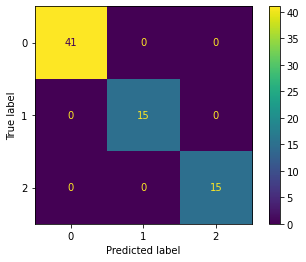

In [ ]:
cm = confusion_matrix(q1,p1)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
y_t=q1
y_p=p1
accuracy = accuracy_score(y_t, y_p)
print('Accuracy: %f' % accuracy)
# # precision tp / (tp + fp)
precision = precision_score(y_t,y_p,average="macro")
print('Precision: %f' % precision)
# # recall: tp / (tp + fn)
recall=recall_score(y_t, y_p, average="macro")
print('Recall: %f' % recall)
# # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_t,y_p,average="macro")
print('F1 score: %f' % f1)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
